In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import pyspark
import logging

from pyspark.sql.types import *
from pyspark import SparkContext
from pyspark.sql import SQLContext 
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinMaxScaler
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Spark_RandomForestRegression_Ener20.com") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
logging.getLogger("py4j").setLevel(logging.ERROR)
from pyspark.sql.functions import col
from pyspark.sql.utils import AnalysisException
import os

main_folder = '/Volumes/G Drive/enertalk/20'

# Iterate over subfolders in the main folder
for subfolder in os.listdir(main_folder):
    if subfolder == '.DS_Store':
        continue

    subfolder_path = os.path.join(main_folder, subfolder)

    if not os.path.isdir(subfolder_path):
        continue

    try:
        # Load the fridge data
        fridge_file = os.path.join(subfolder_path, '01_fridge.parquet.gzip')
        fridge_data = spark.read.parquet(fridge_file)

        # Load the rice cooker data
        rice_cooker_file = os.path.join(subfolder_path, '02_rice-cooker.parquet.gzip')
        rice_cooker_data = spark.read.parquet(rice_cooker_file)

        # Load the total data
        total_file = os.path.join(subfolder_path, '00_total.parquet.gzip')
        total_data = spark.read.parquet(total_file)
        
        
        # load the kimchi refrigerator (used speciffically for korean food)
        kimchi_fridge_file = os.path.join(subfolder_path, '03_kimchi-fridge.parquet.gzip')
        kimchi_fridge_data = spark.read.parquet(kimchi_fridge_file)
       

   


    except AnalysisException as e:
        # Handle the case when a file is not found
        print(f"Skipping folder {subfolder}: {e}")
        continue

        
# we performed a file skip, since there are going to be days for example that some appliances are not functioning such as the tv (or maybe
# they were not recorded). Since we are going to join the data in one dataset (pyspark dataframe) later we do not have to worry
# currently...

# Each folder tat is printed to be skipped is named after the date of the data records e.g. 20161125 is the 25th of November 2016 on the 
# 00 building of the enertalk dataset and from the parquet file names we can see what appliance is missing records on that specific date/subfolder

23/06/06 02:09:17 WARN Utils: Your hostname, Evangeloss-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.2.5 instead (on interface en0)
23/06/06 02:09:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/06 02:09:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from functools import reduce  
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
from pyspark.sql import DataFrame

join_data = {'fridge': fridge_data, 'rice': rice_cooker_data, 'kimchi_fridge': kimchi_fridge_data}

for i, df_name in join_data.items():
    globals()["data_" + i] = total_data.join(df_name, on='timestamp')
    globals()["data_" + i] = globals()["data_" + i].drop('timestamp', '__index_level_0__')
    globals()["data_" + i] = globals()["data_" + i].toDF('total_active_power', 'total_reactive_power',
                                                         i + '_active_power', i + '_reactive_power')
    for column in globals()["data_" + i].columns:
        globals()["data_" + i] = globals()["data_" + i].withColumn(column, col(column).cast(DoubleType()))

In [3]:
from pyspark.sql.functions import col

for i in ['fridge', 'rice', 'kimchi_fridge']:
    
    globals()["data_" + i] = globals()["data_" + i].dropna()
    
    globals()["data_" + i].show()
    
    
    print(globals()["data_" + i].printSchema())

+------------------+--------------------+-------------------+---------------------+
|total_active_power|total_reactive_power|fridge_active_power|fridge_reactive_power|
+------------------+--------------------+-------------------+---------------------+
|            603.74|              -25.36|                0.0|                  0.0|
|            598.71|              -27.37|                0.0|                  0.0|
|            594.25|              -28.17|                0.0|                  0.0|
|            604.74|              -29.34|                4.9|                 1.26|
|            597.69|              -31.33|               4.96|                 1.24|
|            594.53|              -31.23|               4.91|                 1.27|
|            624.03|              -33.75|               4.93|                 1.22|
|            615.71|              -34.02|                4.9|                 1.26|
|            619.41|              -35.84|               4.95|               

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import lit

# Create dictionaries to hold the input and output column names for each device
input_cols = {
    'fridge': ['total_active_power', 'total_reactive_power'],
    'rice': ['total_active_power', 'total_reactive_power'],
    'kimchi_fridge': ['total_active_power', 'total_reactive_power']
}

output_cols = {
    'fridge': ['fridge_active_power', 'fridge_reactive_power'],
    'rice': ['rice_active_power', 'rice_reactive_power'],
    'kimchi_fridge': ['kimchi_fridge_active_power', 'kimchi_fridge_reactive_power']
}

# Create empty dictionaries to hold the pipeline models and predictions for each device
pipeline_models = {}
predictions = {}

train_data_list = []
test_data_list = []
trains = []
tests = []

i = 0
# Iterate over the devices
for device in ['fridge', 'rice', 'kimchi_fridge']:
    # Get the input and output column names for the current device
    input_cols_device = input_cols[device]
    output_cols_device = output_cols[device]

    # Get the DataFrame for the current device
    df = globals()["data_" + device]

    # Split the data into train and test sets
    train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
    
    # Add train and test data to the respective lists
    train_data_list.append(train_data)
    test_data_list.append(test_data)

    # Create vector assembler for input columns
    assembler = VectorAssembler(inputCols=input_cols_device, outputCol='features')

    # Create scaler
    scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

    # Create GBT regressor
    rf = RandomForestRegressor(featuresCol='scaled_features', labelCol=output_cols_device[0], numTrees=100, maxDepth=20)

    # Create pipeline
    pipeline = Pipeline(stages=[assembler, scaler, rf])

    # Fit pipeline
    pipeline_model = pipeline.fit(train_data_list[i])

    # Make predictions on the test data
    predictions_device = pipeline_model.transform(test_data_list[i])

    # Add pipeline model and predictions to dictionaries
    pipeline_models[device] = pipeline_model
    predictions[device] = predictions_device

    # Evaluate the model on the predicted column
    evaluator = RegressionEvaluator(labelCol=output_cols_device[0], predictionCol='prediction', metricName='rmse')
    mse_evaluator = RegressionEvaluator(labelCol=output_cols_device[0], predictionCol='prediction', metricName='mse')
    rmse = evaluator.evaluate(predictions_device)
    mse = mse_evaluator.evaluate(predictions_device)
    mae = evaluator.evaluate(predictions_device, {evaluator.metricName: 'mae'})
    r2 = evaluator.evaluate(predictions_device, {evaluator.metricName: 'r2'})

    # Print the evaluation metrics
    print(f"Metrics for {device}:")
    print("RMSE:", rmse)
    print("MSE:", mse)
    print("MAE:", mae)
    print("R2:", r2)
    trains.append(train_data_list[i])
    tests.append(test_data_list[i])
    i = i +1 
    


Metrics for fridge:
RMSE: 31.013206630650203
MSE: 961.8189855154056
MAE: 28.644189036327514
R2: 0.00928887166983583


Metrics for rice:
RMSE: 0.05942041363449813
MSE: 0.0035307855564948513
MAE: 0.04727397174967693
R2: -0.0035293888347616154


Metrics for kimchi_fridge:
RMSE: 21.41822049474185
MSE: 458.7401691613798
MAE: 2.6049393548036086
R2: 0.7315314915566733


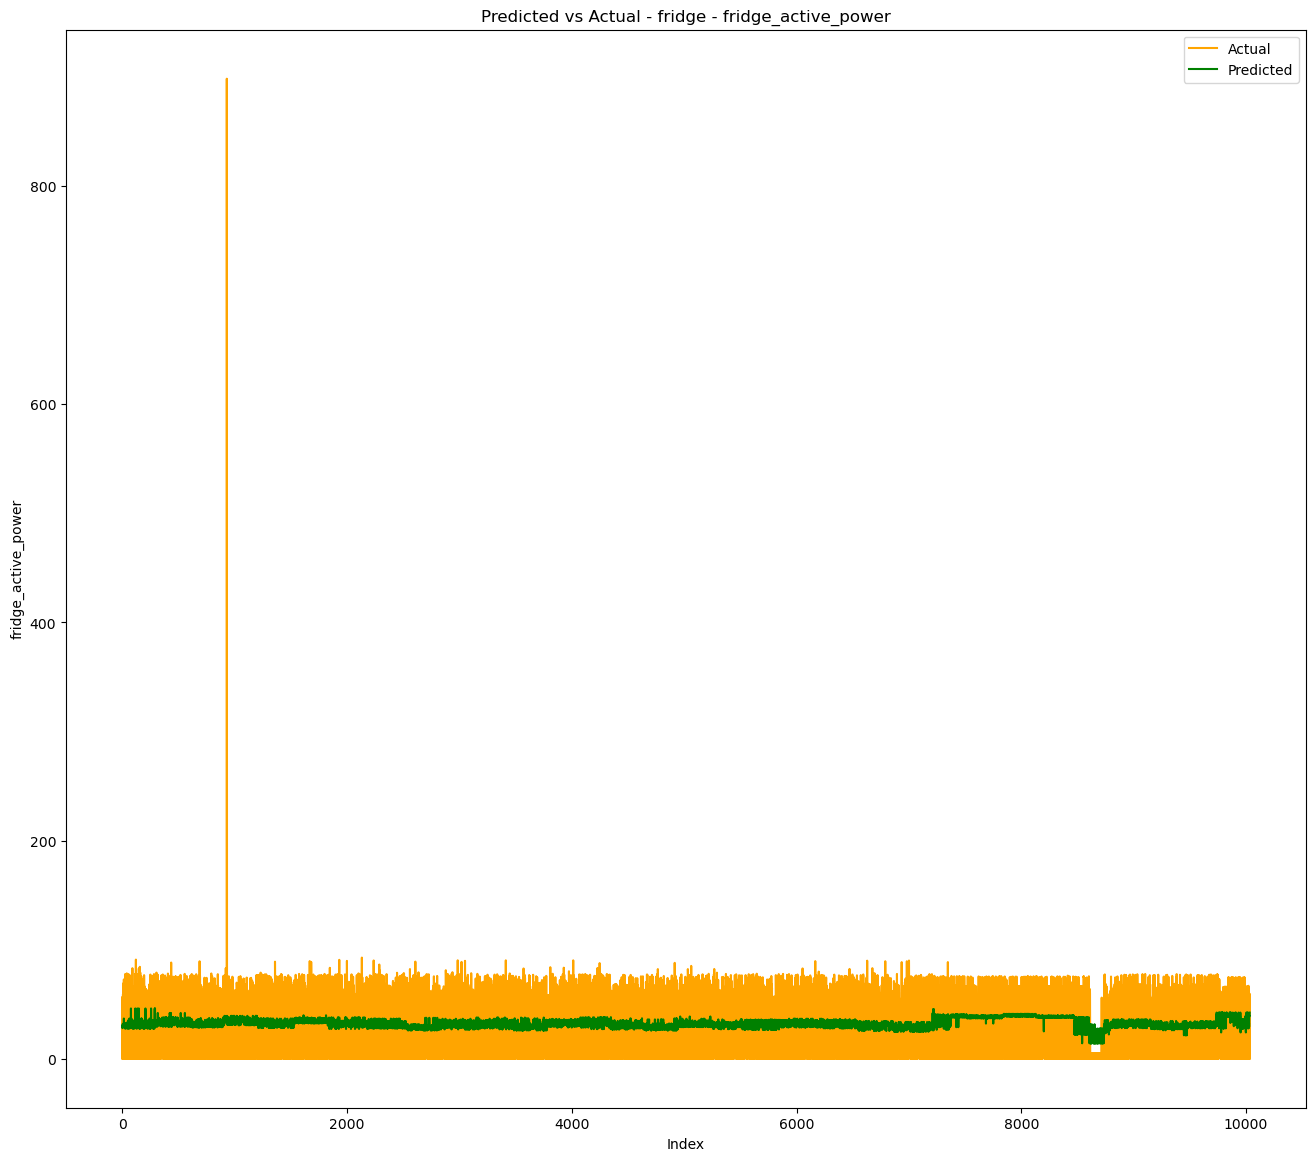

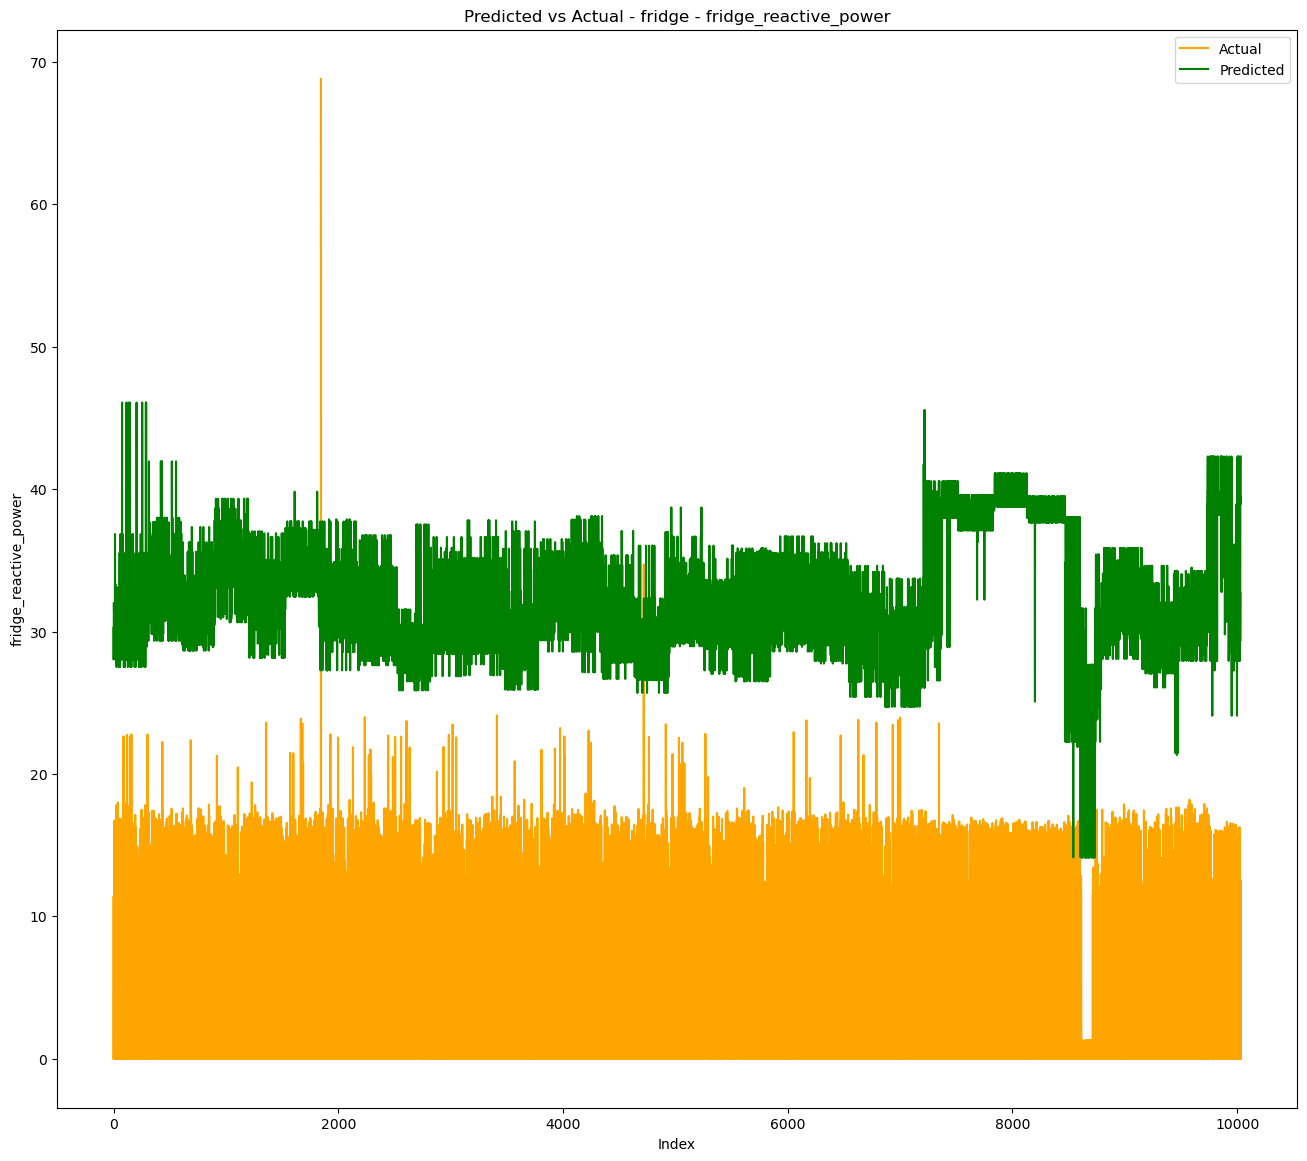

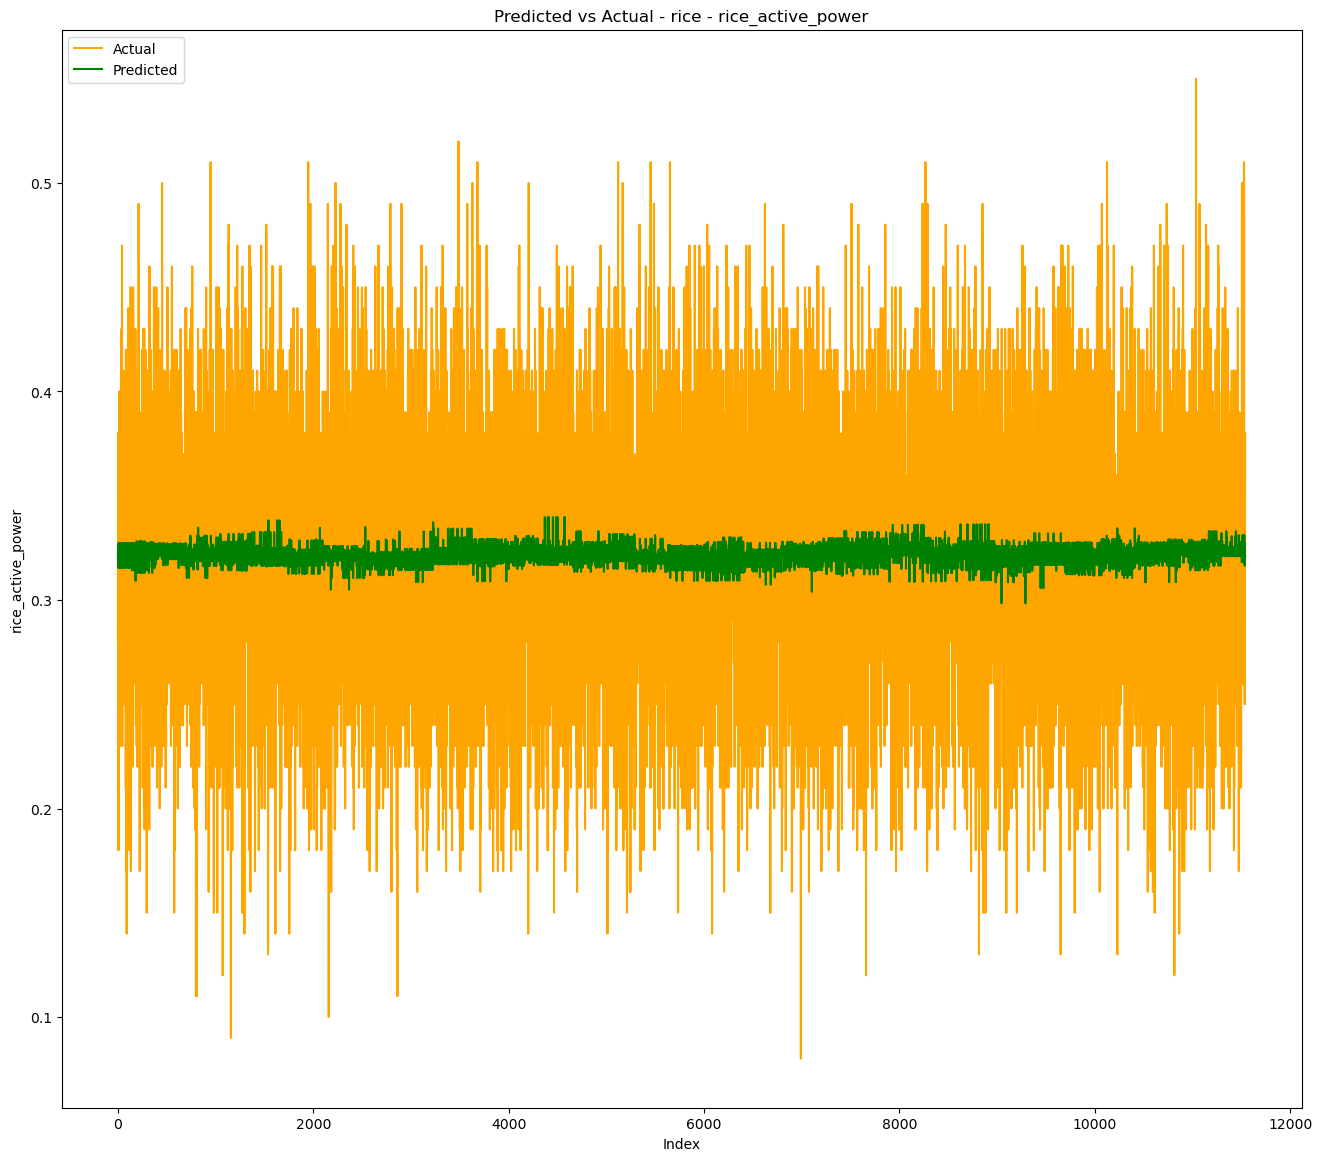

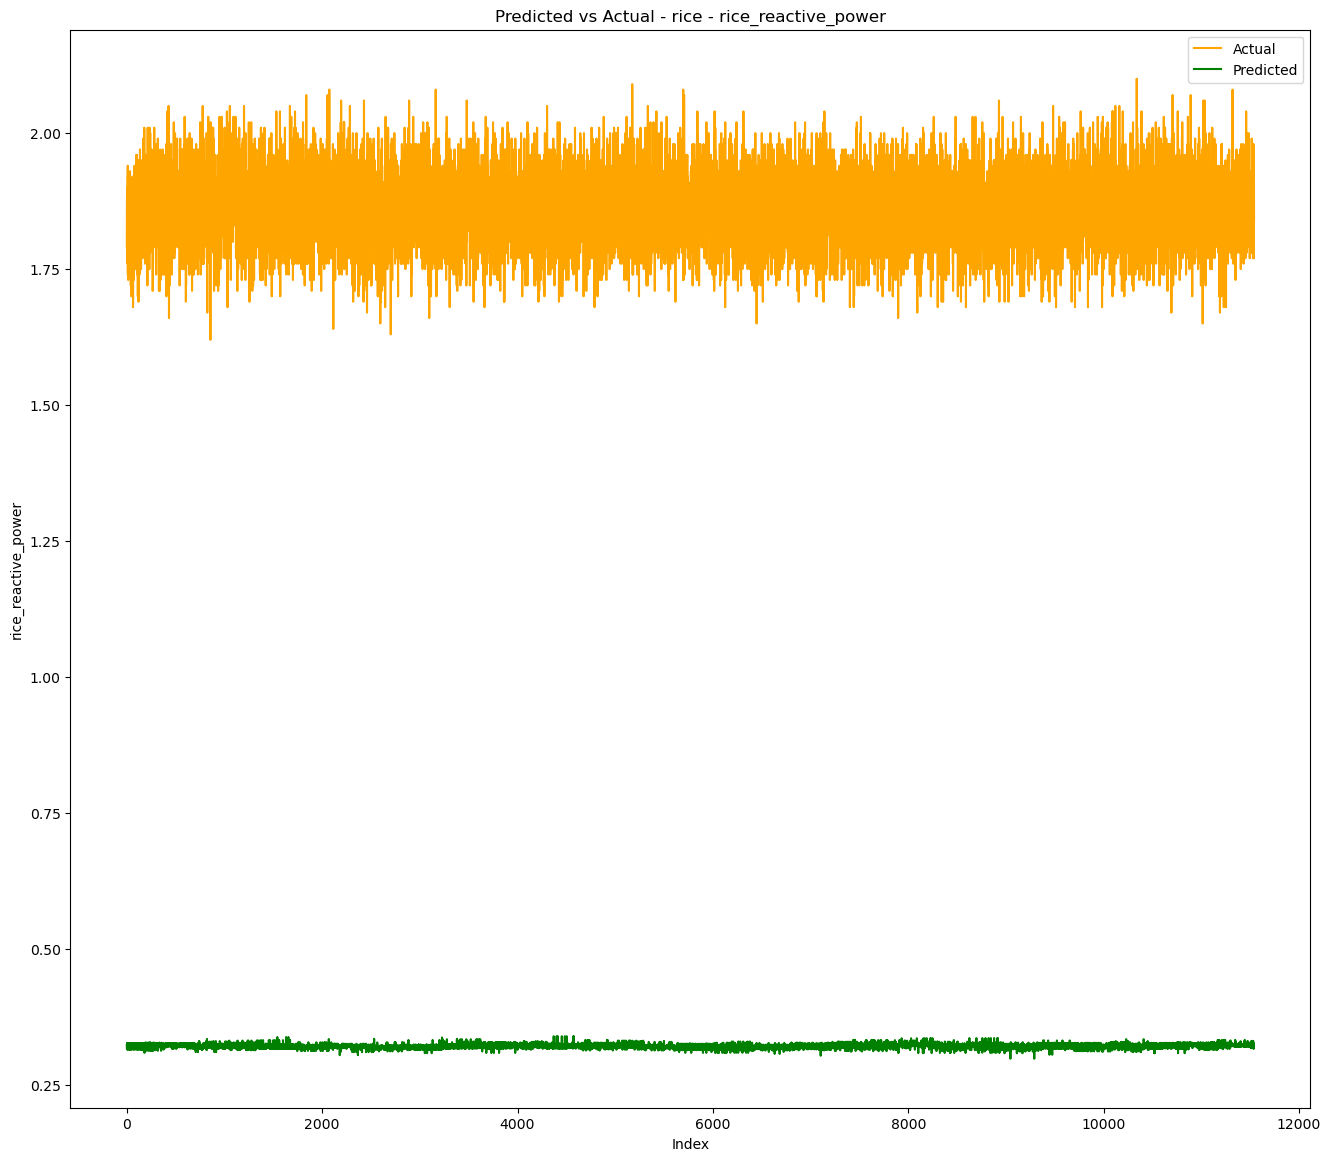

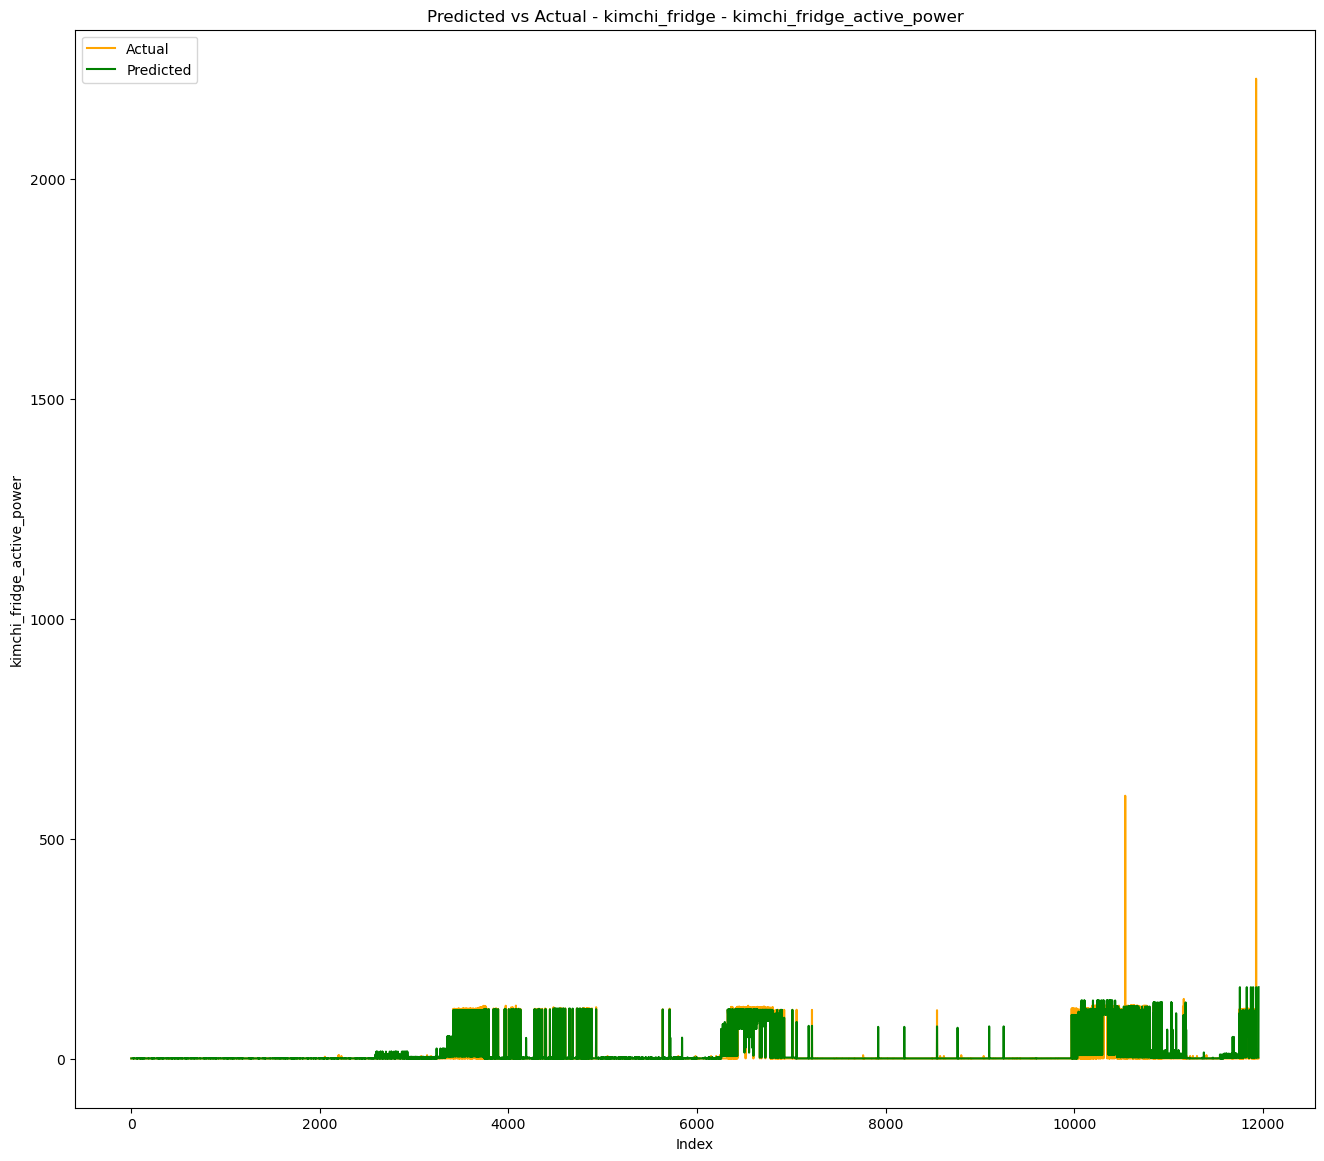

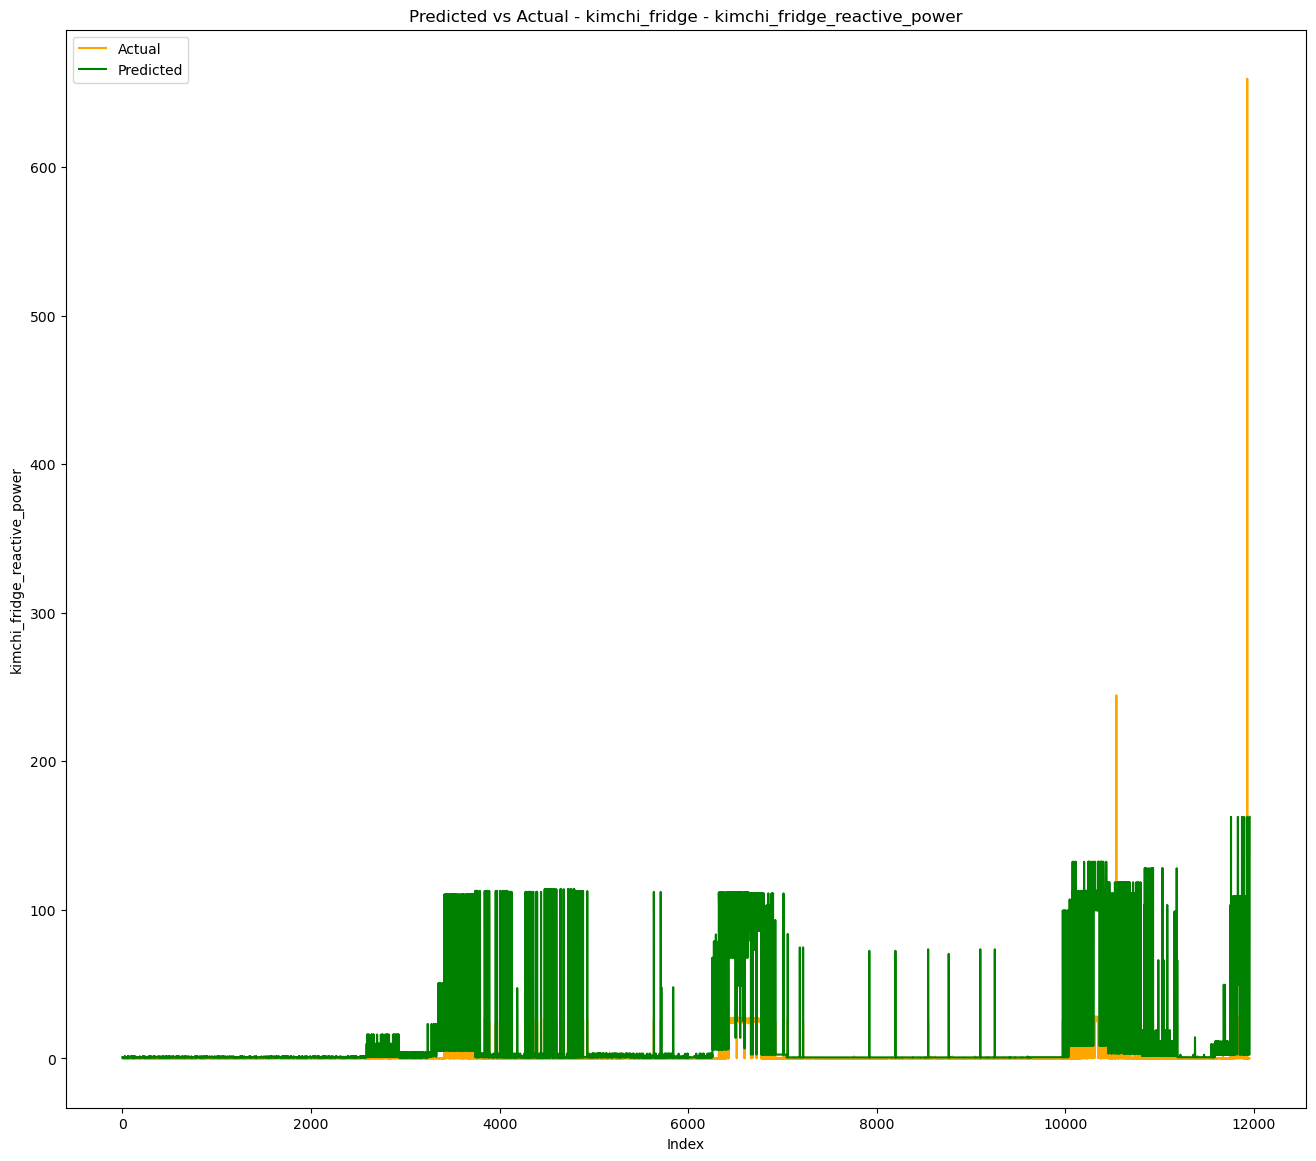

In [6]:
j=0
preds_actual_dict = {}
for device, cols in output_cols.items():
    # Get the pipeline model for the current device
    pipeline_model = pipeline_models[device]

    # Get the original test data for the current device
    test_data = tests[j]

    # Transform the original test data using the pipeline model
    predictions_device = pipeline_model.transform(test_data)
    
    j = j + 1

    for i in range(len(cols)):
        # Get the output column name for the current device and metric
        output_col = cols[i]

        # Get the predicted and actual values as Pandas DataFrames
        preds = predictions_device.select('prediction').toPandas()
        actual_values = predictions_device.select(output_col).toPandas()

        # Add the predicted and actual values to the dictionary
        preds_actual_dict[(device, output_col)] = (preds, actual_values)

# Plot the predicted and actual values for each model
for (device, output_col), (preds, actual_values) in preds_actual_dict.items():
    plt.figure(figsize=(16, 14))
    plt.plot(actual_values, color='orange', label='Actual')
    plt.plot(preds, color='green', label='Predicted')
    plt.xlabel('Index')
    plt.ylabel(output_col)
    plt.title(f"Predicted vs Actual - {device} - {output_col}")
    plt.legend()
    plt.show()



Metrics for fridge - fridge_active_power:
RMSE: 31.013206630650203
MSE: 961.8189855154056
MAE: 28.644189036327514
R2: 0.00928887166983583


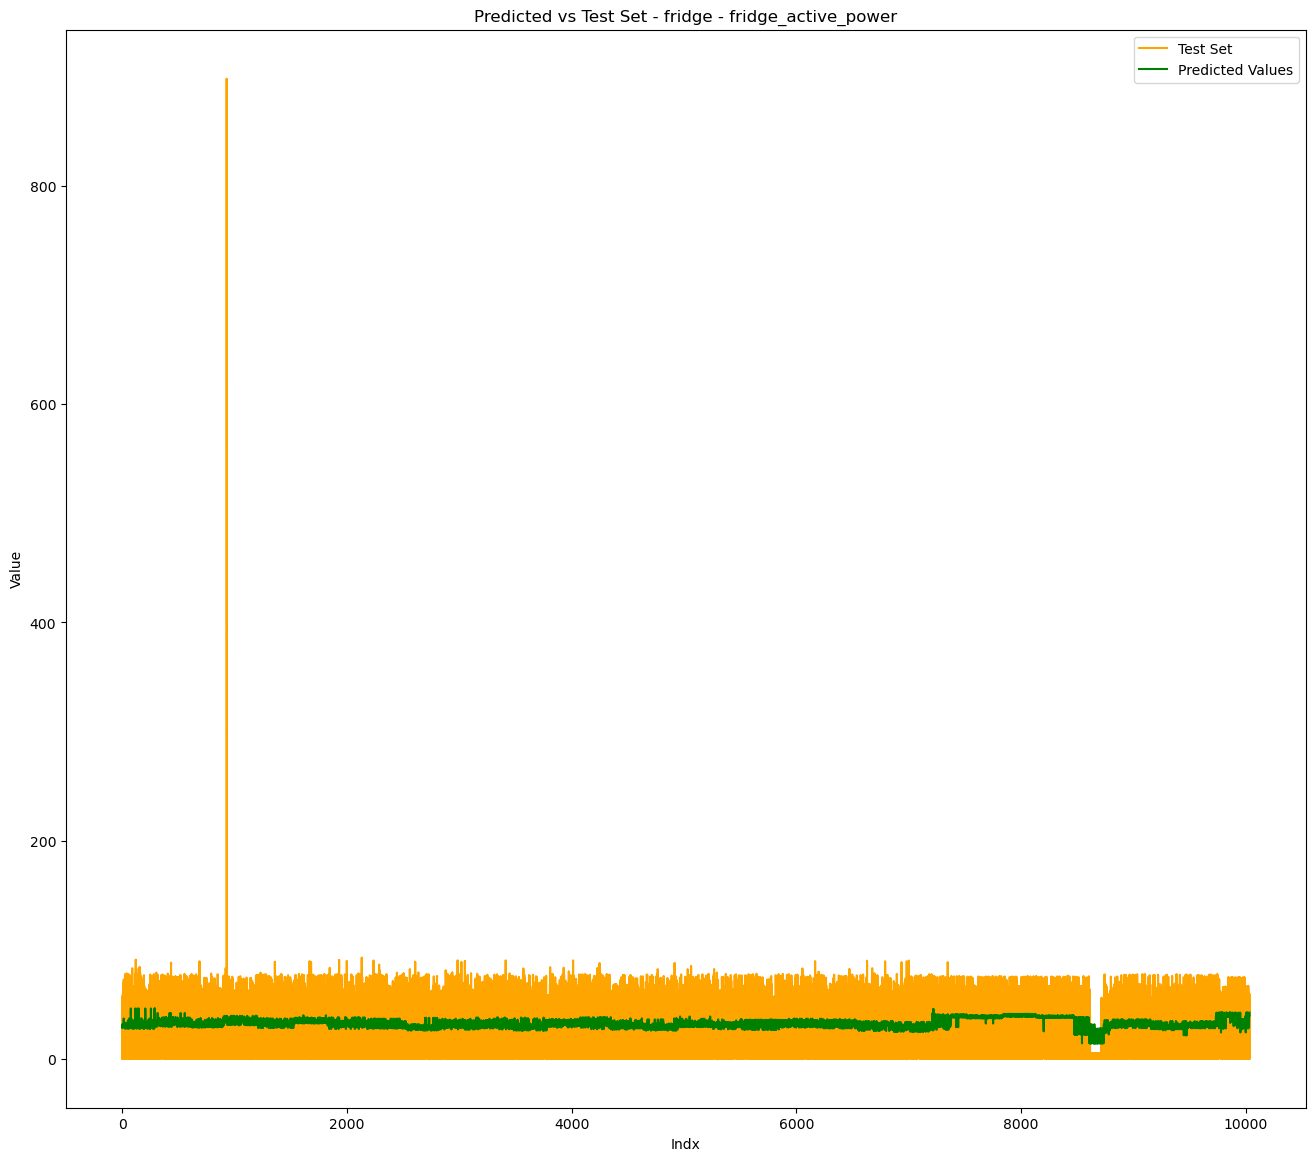

Metrics for fridge - fridge_reactive_power:
RMSE: 6.839178552086105
MSE: 46.7743632673146
MAE: 6.53284484533928
R2: 0.009028829674356476


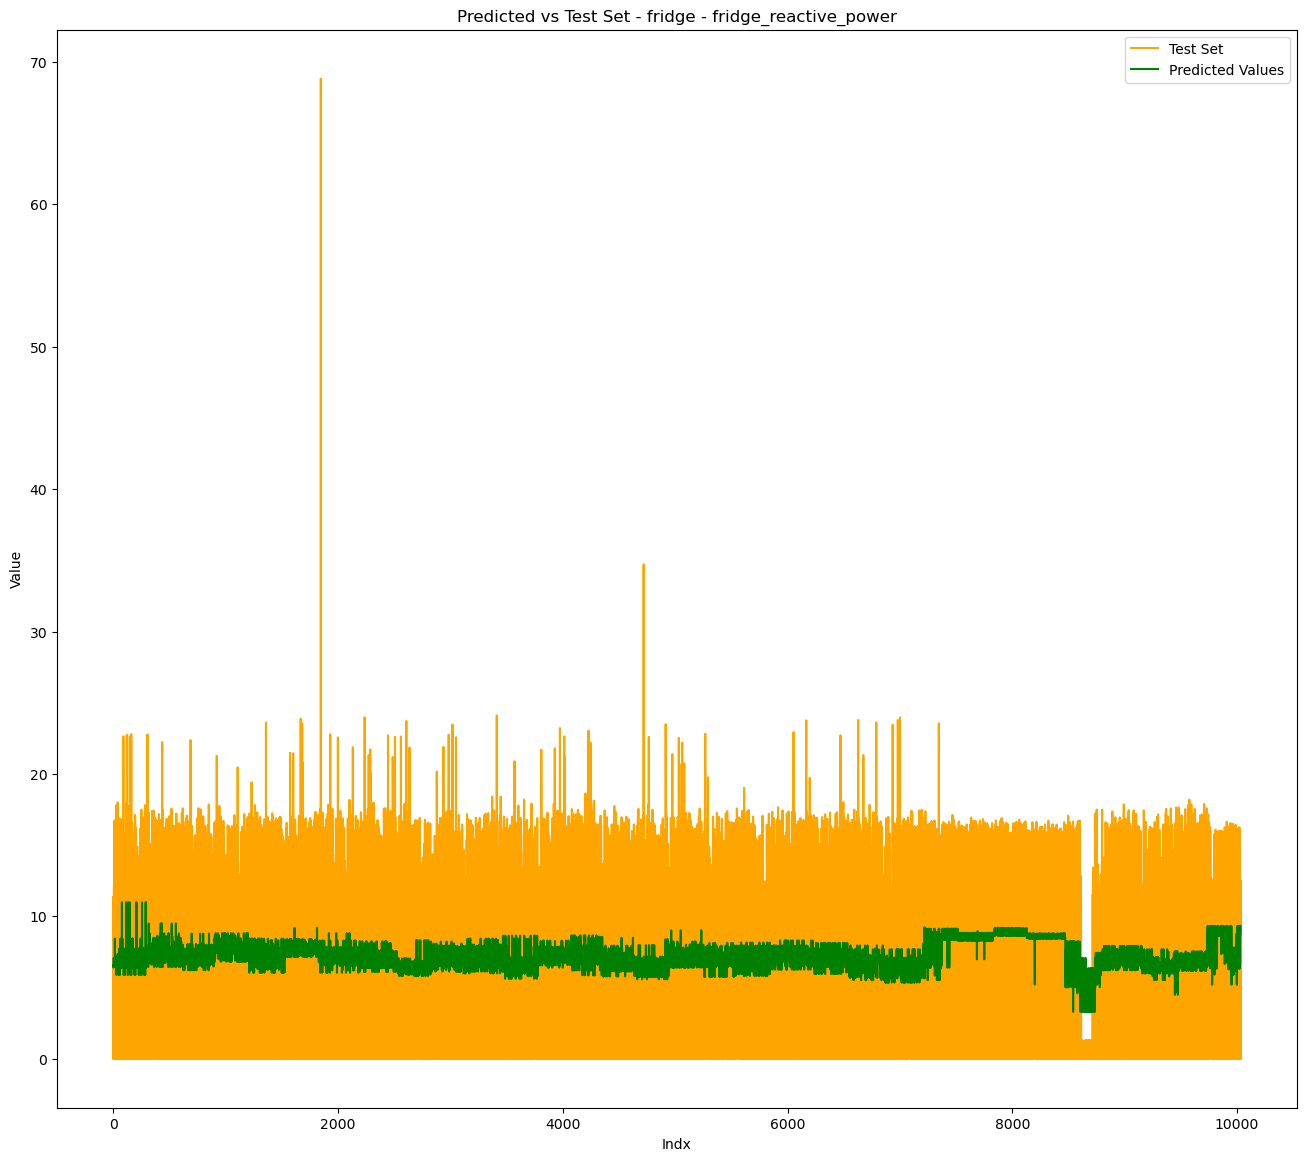

Metrics for rice - rice_active_power:
RMSE: 0.05942041363449813
MSE: 0.0035307855564948513
MAE: 0.04727397174967693
R2: -0.0035293888347616154


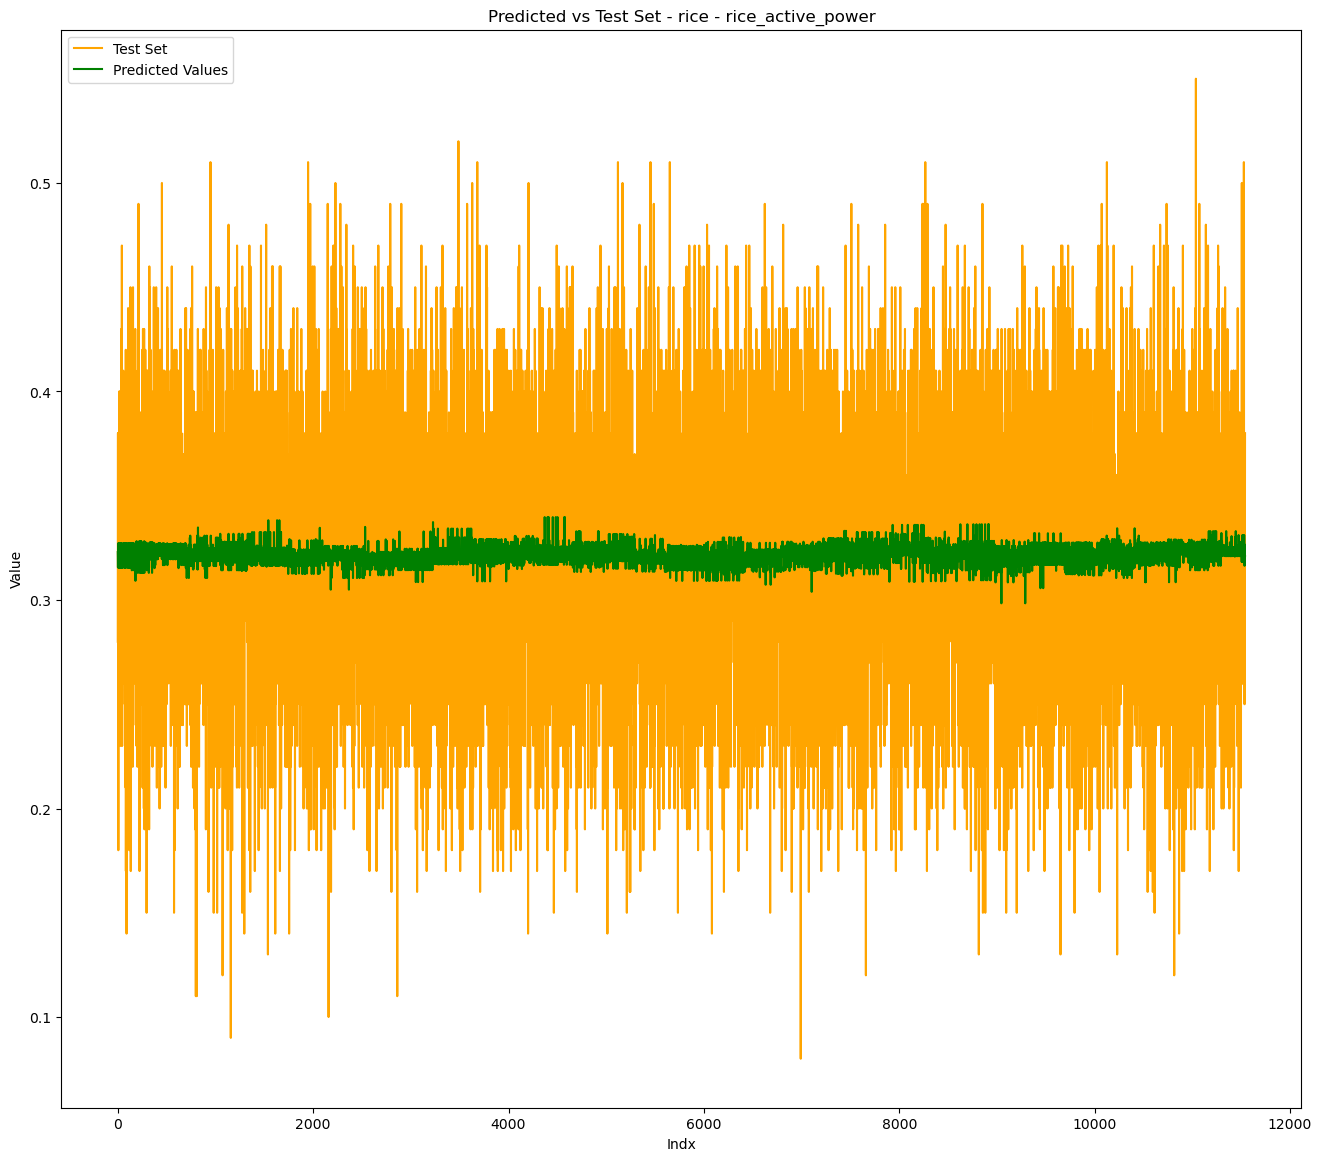

Metrics for rice - rice_reactive_power:
RMSE: 0.06486923802159598
MSE: 0.004208018041502474
MAE: 0.051775016260988724
R2: 0.02343966775004558


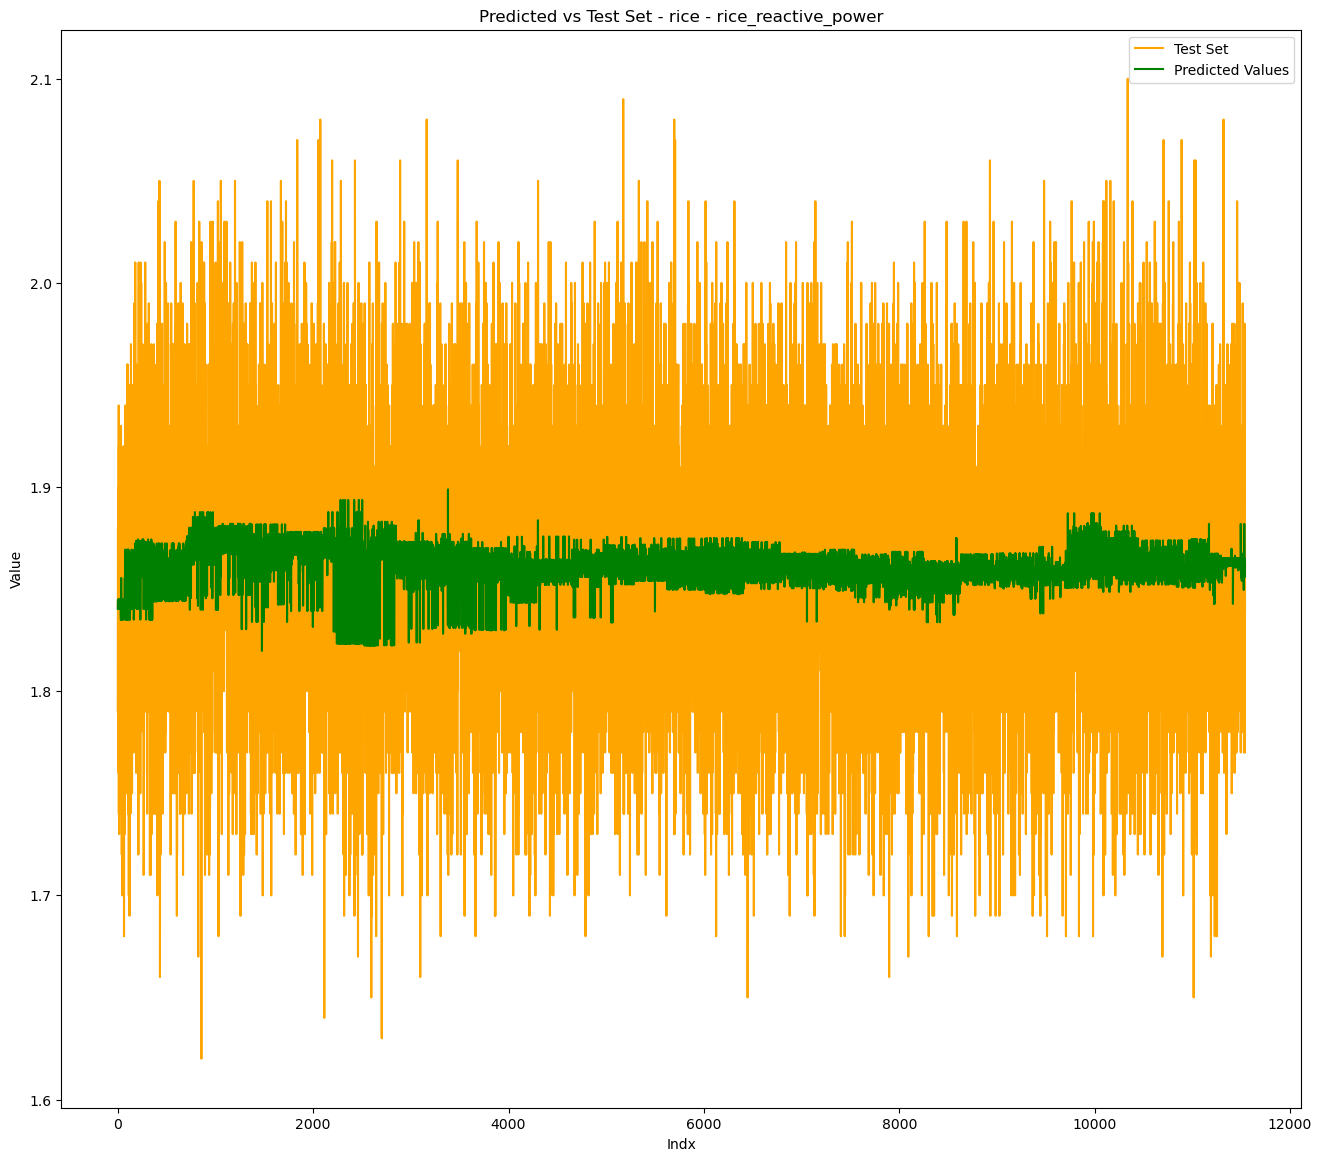

Metrics for kimchi_fridge - kimchi_fridge_active_power:
RMSE: 21.41822049474185
MSE: 458.7401691613798
MAE: 2.6049393548036086
R2: 0.7315314915566733


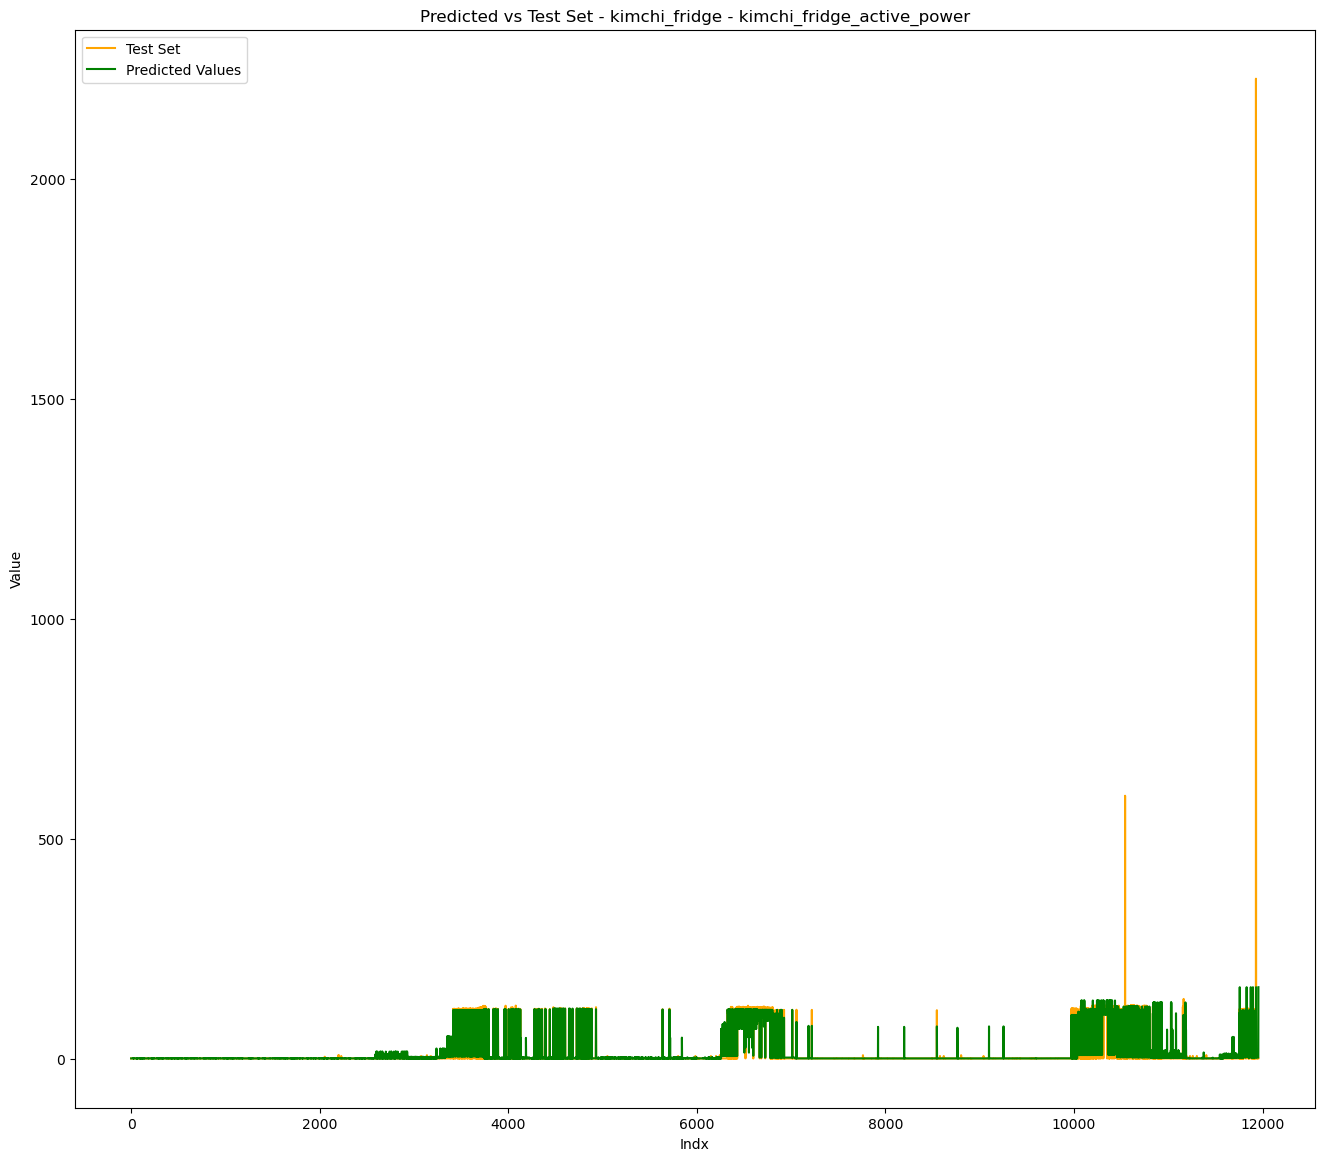

Metrics for kimchi_fridge - kimchi_fridge_reactive_power:
RMSE: 6.380875127522159
MSE: 40.71556739303092
MAE: 0.6802765444534454
R2: 0.6219063539356497


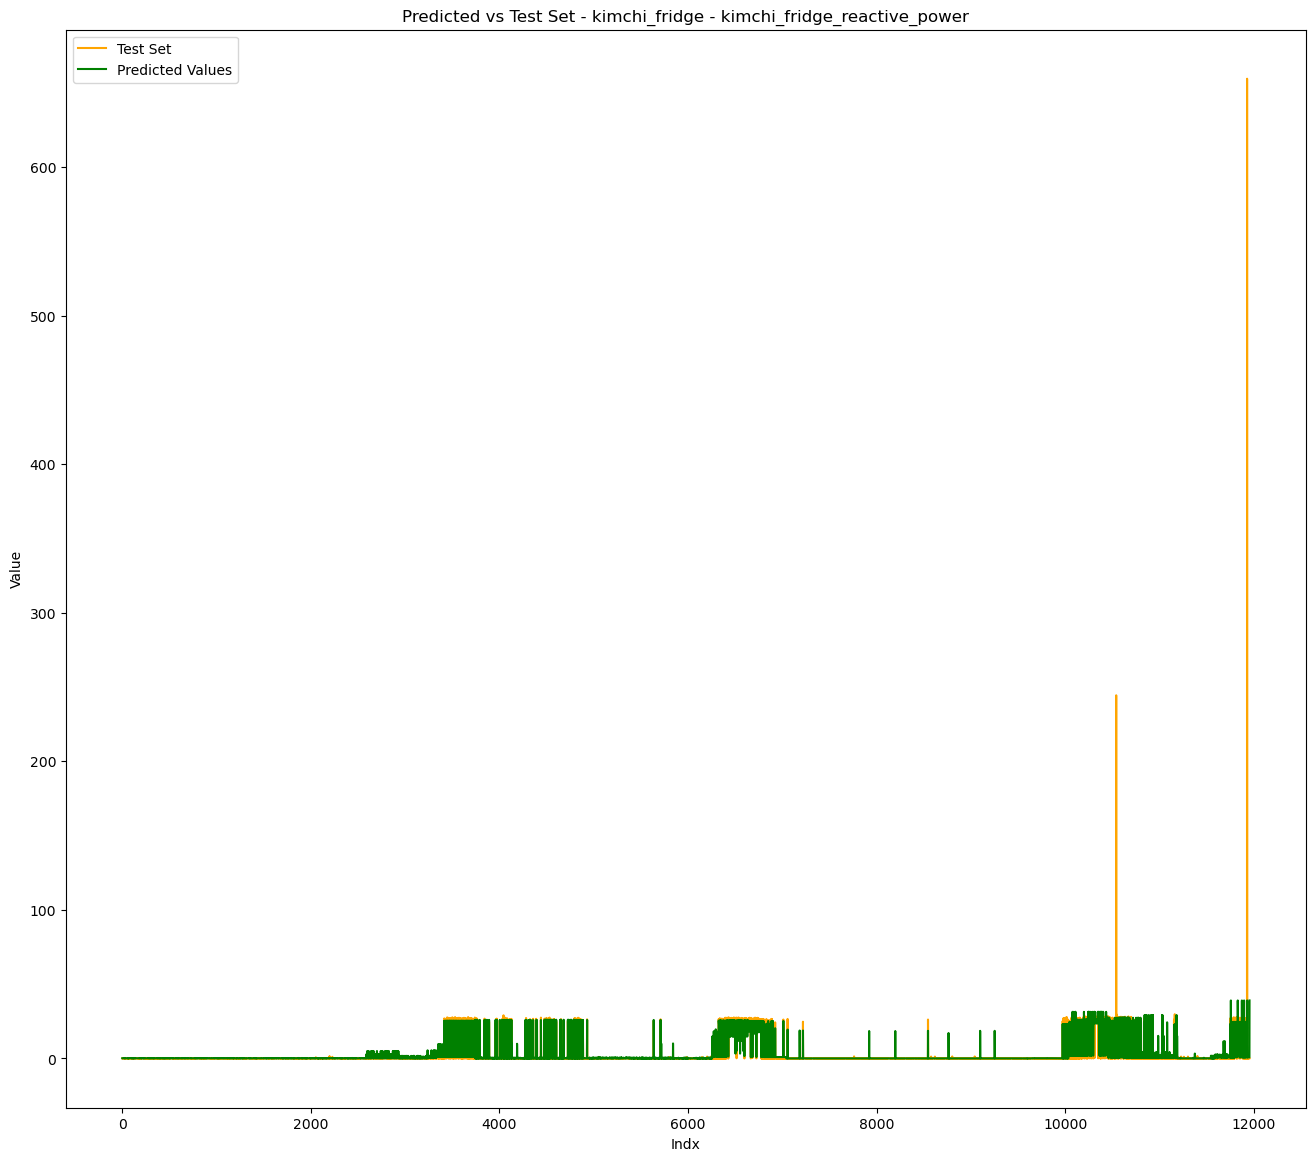

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import lit

# Create dictionaries to hold the input and output column names for each device
input_cols = {
    'fridge': ['total_active_power', 'total_reactive_power'],
    'rice': ['total_active_power', 'total_reactive_power'],
    'kimchi_fridge': ['total_active_power', 'total_reactive_power']
}

output_cols = {
    'fridge': ['fridge_active_power', 'fridge_reactive_power'],
    'rice': ['rice_active_power', 'rice_reactive_power'],
    'kimchi_fridge': ['kimchi_fridge_active_power', 'kimchi_fridge_reactive_power']
}

# Create empty dictionaries to hold the pipeline models and predictions for each device
pipeline_models = {}
predictions = {}

train_data_list = []
test_data_list = []
trains = []
tests = []

i = 0
# Iterate over the devices
for device in ['fridge', 'rice', 'kimchi_fridge']:
    # Get the input and output column names for the current device
    input_cols_device = input_cols[device]
    output_cols_device = output_cols[device]

    # Get the DataFrame for the current device
    df = globals()["data_" + device]

    # Split the data into train and test sets
    train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
    
    # Create empty lists to hold train and test datasets for each feature
    train_data_features = []
    test_data_features = []

    # Iterate over the output columns for the current device
    for output_col in output_cols_device:
        # Create vector assembler for input columns
        assembler = VectorAssembler(inputCols=input_cols_device, outputCol='features')

        # Create scaler
        scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

        # Create GBT regressor
        gbt = RandomForestRegressor(featuresCol='scaled_features', labelCol=output_col, numTrees=100, maxDepth=20)

        # Create pipeline
        pipeline = Pipeline(stages=[assembler, scaler, gbt])

        # Fit pipeline
        pipeline_model = pipeline.fit(train_data)

        # Make predictions on the test data
        predictions_device = pipeline_model.transform(test_data)

        # Add pipeline model and predictions to dictionaries
        if device not in pipeline_models:
            pipeline_models[device] = []
        pipeline_models[device].append(pipeline_model)

        if device not in predictions:
            predictions[device] = []
        predictions[device].append(predictions_device)

        # Evaluate the model on the predicted column
        evaluator = RegressionEvaluator(labelCol=output_col, predictionCol='prediction', metricName='rmse')
        mse_evaluator = RegressionEvaluator(labelCol=output_col, predictionCol='prediction', metricName='mse')
        rmse = evaluator.evaluate(predictions_device)
        mse = mse_evaluator.evaluate(predictions_device)
        mae = evaluator.evaluate(predictions_device, {evaluator.metricName: 'mae'})
        r2 = evaluator.evaluate(predictions_device, {evaluator.metricName: 'r2'})

        # Print the evaluation metrics
        print(f"Metrics for {device} - {output_col}:")
        print("RMSE:", rmse)
        print("MSE:", mse)
        print("MAE:", mae)
        print("R2:", r2)

        # Plot line plot for predicted values against test set
        # Plot line plot for predicted values against test set
        test_values = test_data.select(output_col).collect()
        predicted_values = predictions_device.select('prediction').collect()
        plt.figure(figsize = (16,14))
        plt.plot(test_values, color='orange', label='Test Set')
        plt.plot(predicted_values, color='green', label='Predicted Values')
        plt.xlabel("Indx")
        plt.ylabel("Value")
        plt.title(f"Predicted vs Test Set - {device} - {output_col}")
        plt.legend()
        plt.show()


        # Append train and test datasets to the respective lists
        train_data_features.append(train_data)
        test_data_features.append(test_data)

    # Append the train and test datasets for the current device to the main lists
    trains.append(train_data_features)
    tests.append(test_data_features)
    i += 1


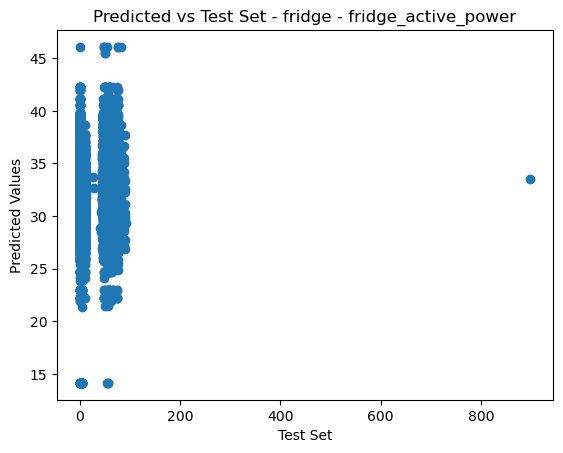

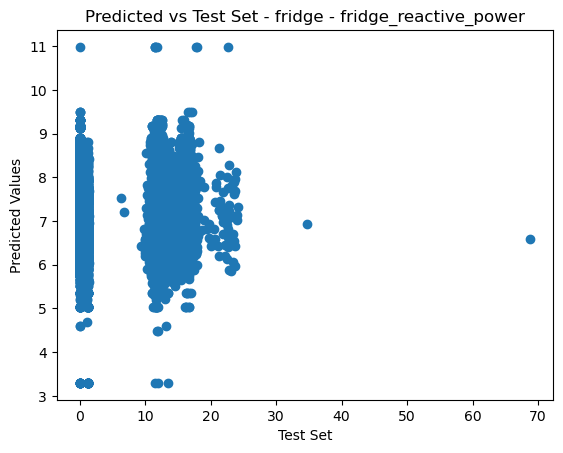

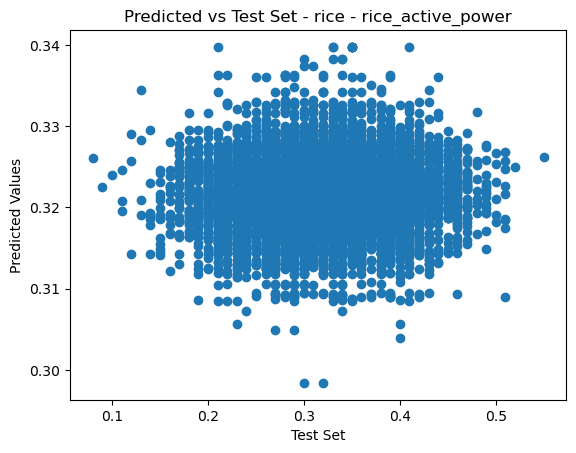

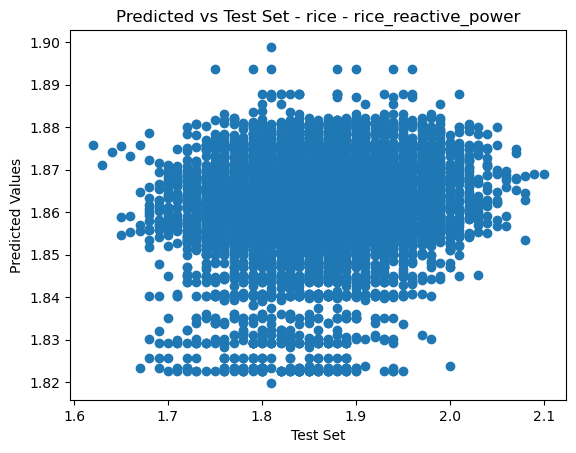

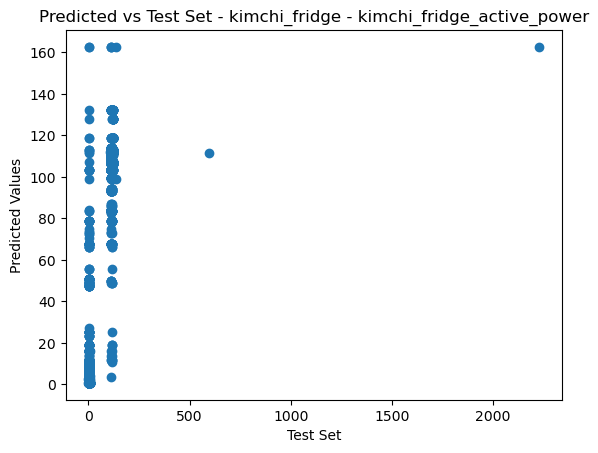

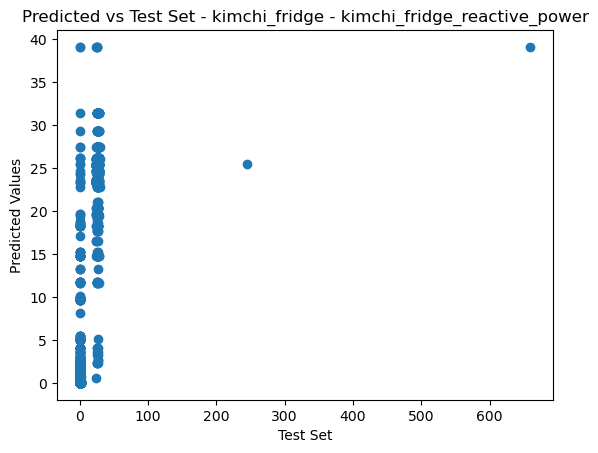

In [10]:
# Iterate over the devices
for i, device in enumerate(['fridge', 'rice', 'kimchi_fridge']):
    # Iterate over the output columns for the current device
    for j, output_col in enumerate(output_cols[device]):
        # Get the test data and predictions for the current device and output column
        test_values = tests[i][j].select(output_col).collect()
        predicted_values = predictions[device][j].select('prediction').collect()

        # Create a scatter plot for predicted vs test values
        plt.scatter(test_values, predicted_values)
        plt.xlabel("Test Set")
        plt.ylabel("Predicted Values")
        plt.title(f"Predicted vs Test Set - {device} - {output_col}")
        plt.show()
